In [3]:
from google.colab import files
uploaded = files.upload()


Saving cs-test.csv to cs-test.csv
Saving cs-training.csv to cs-training.csv
Saving Data Dictionary.xls to Data Dictionary.xls
Saving sampleEntry.csv to sampleEntry.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load training data
df = pd.read_csv('cs-training.csv')
df = df.rename(columns={'SeriousDlqin2yrs': 'target'})  # Rename target column
df.drop(columns=['Unnamed: 0'], inplace=True)  # Remove index column if exists

df.head()


,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
# Show missing value counts
print(df.isnull().sum())

# Replace missing monthly income with median
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())

# Fill NumberOfDependents NA with 0
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)


target                                      0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [7]:
df['DebtRatio'] = df['DebtRatio'].clip(upper=1)  # cap at 100%
df['MonthlyDebt'] = df['DebtRatio'] * df['MonthlyIncome']
df['DebtPerPerson'] = df['MonthlyDebt'] / (df['NumberOfDependents'] + 1)

df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)


In [8]:
X = df.drop('target', axis=1)
y = df['target']


In [9]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


Random Forest Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89     27925
           1       0.88      0.93      0.90     28065

    accuracy                           0.90     55990
   macro avg       0.90      0.90      0.90     55990
weighted avg       0.90      0.90      0.90     55990

XGBoost Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84     27925
           1       0.83      0.85      0.84     28065

    accuracy                           0.84     55990
   macro avg       0.84      0.84      0.84     55990
weighted avg       0.84      0.84      0.84     55990



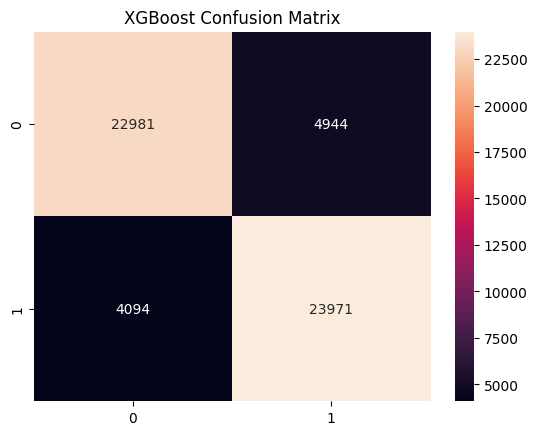

In [12]:
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title('XGBoost Confusion Matrix')
plt.show()


In [14]:
test_df = pd.read_csv('cs-test.csv')
test_df.drop(columns=['Unnamed: 0'], inplace=True)

# Fill missing values as before
test_df['MonthlyIncome'] = test_df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
test_df['NumberOfDependents'] = test_df['NumberOfDependents'].fillna(0)

# Same feature engineering
test_df['MonthlyDebt'] = test_df['DebtRatio'] * test_df['MonthlyIncome']
test_df['DebtPerPerson'] = test_df['MonthlyDebt'] / (test_df['NumberOfDependents'] + 1)
test_df['RevolvingUtilizationOfUnsecuredLines'] = test_df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)

# Drop the target column from the test set before scaling
test_df.drop(columns=['SeriousDlqin2yrs'], inplace=True)

# Scale test set
X_test_final = scaler.transform(test_df)

# Predict
test_predictions = xgb.predict(X_test_final)
print(test_predictions[:10])  # Sample predictions


[1 0 0 0 0 0 0 0 0 1]


In [20]:
def credit_risk_system(input_data, model, scaler):
    # Make a copy to avoid modifying original
    df = input_data.copy()

    # Clean: Handle missing values
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

    # Feature Engineering
    df['MonthlyDebt'] = df['DebtRatio'] * df['MonthlyIncome']
    df['DebtPerPerson'] = df['MonthlyDebt'] / (df['NumberOfDependents'] + 1)
    df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)

    # Drop the target column ('SeriousDlqin2yrs') before scaling,
    # as the scaler was fitted on data without this column.
    if 'SeriousDlqin2yrs' in df.columns:
        df.drop(columns=['SeriousDlqin2yrs'], inplace=True)

    # Scaling
    X_scaled = scaler.transform(df)

    # Predict
    risk_flags = model.predict(X_scaled)

    # Append predictions (append to the original df, as scaling is done on features)
    # If you want the predictions appended to the dataframe after scaling,
    # you need to handle the index alignment, or simply add it to the original df.
    # Appending to the original df might be more useful if you want to see the
    # original data alongside the prediction. Let's append to the original input_data copy.
    df['RiskFlag'] = risk_flags # Add the risk flags to the processed dataframe before returning


    return df

# Rest of the code remains the same
test_df = pd.read_csv('cs-test.csv')
test_df.drop(columns=['Unnamed: 0'], inplace=True)

# Use XGBoost (or RandomForest) to flag high-risk customers
flagged_customers = credit_risk_system(test_df, xgb, scaler)

# View the first few flagged predictions
flagged_customers[['RiskFlag']].head(10)

,RiskFlag
0,1
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,1


In [21]:
print("High-Risk (1) vs Low-Risk (0):\n")
print(flagged_customers['RiskFlag'].value_counts())


High-Risk (1) vs Low-Risk (0):

RiskFlag
0    79924
1    21579
Name: count, dtype: int64


In [22]:
flagged_customers[['RiskFlag']].to_csv("flagged_customers.csv", index=False)

from google.colab import files
files.download("flagged_customers.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

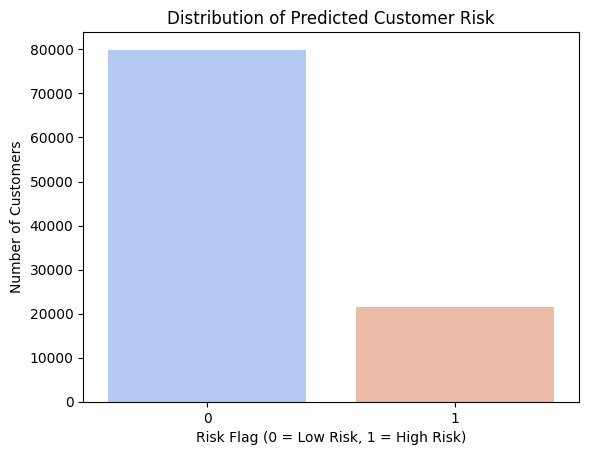

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart of RiskFlag counts
sns.countplot(x='RiskFlag', data=flagged_customers, palette='coolwarm')
plt.title('Distribution of Predicted Customer Risk')
plt.xlabel('Risk Flag (0 = Low Risk, 1 = High Risk)')
plt.ylabel('Number of Customers')
plt.show()
